In [1]:
'''
Last Updated 12/8/2021, V2
This code reads a csv file of shot times, converts the time to UTCDateTime.

Applies a highpass filter to data and uses STA/LTA detection method to save all detections.

Saves a list of detections as a pickle file.

Compares all detections to shot times. May include double counting.

Removes duplicates with a function.
Plots a histogram of how many detections were detected by x number of station.
Shows that large margin of detections were detected by only one station and thus are outliers.

'''

'\nLast Updated 12/7/2021, V2\nThis code reads a csv file of shot times, converts the time to UTCDateTime.\n\nApplies a highpass filter to data and uses STA/LTA detection method to save all detections.\n\nSaves a list of detections as a pickle file.\n\nThe compares the time of detection to all shots and creates a list of matching times and indices.\n\n'

In [58]:
import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client

from obspy.signal.trigger import plot_trigger
import matplotlib.pyplot as plt


from obspy.signal.trigger import trigger_onset
from obspy.signal.trigger import classic_sta_lta

import re
import pickle
import datetime

#%matplotlib notebook

import pandas as pd
from pandas import DataFrame, read_csv
import os
pd.__version__

'1.2.5'

### Imports and formats shot data

In [8]:
data = 'shooting_location_data_new.csv'
df = pd.read_csv(data)
# os.remove(data)
print(df['date'])

0            NaN
1     2019-01-10
2     2019-01-11
3     2019-01-11
4     2019-01-11
         ...    
87    2019-01-14
88    2019-01-14
89    2019-01-14
90    2019-01-14
91    2019-01-14
Name: date, Length: 92, dtype: object


In [11]:
'''
format: 2019-01-08T00:00:00.000000Z
date = year-mm-dd
Unnamed: 5 = hr
Unnamed: 6 = min
Unnamed: 7 = ss.sss
'''

# desire: date + 'T' + hr + ':' + min + ':' + ss + 'Z'

df.dtypes
time_list = []
time_list =  df['date'] + 'T' + df['Unnamed: 5'] + ':' + df['Unnamed: 6'] + ':' + df['Unnamed: 7'] + 'Z'
# time_list =  df['date'] + 'T' + df['Unnamed: 5'] + ':' + df['Unnamed: 6']
time_list = time_list[1:]
for t in time_list:
    print(t)
    
    
'''
Reformats time_list into specific UTCDateTime format

UTCDateTime(year,month,day,hour,min,ssms)

'''
shot_times = []
for t in time_list:
    shot_times.append(UTCDateTime(t, iso8601 = "true"))

for s in shot_times:
    print(s)
    

2019-01-10T23:55:00.017Z
2019-01-11T0:22:00.017Z
2019-01-11T0:37:00.017Z
2019-01-11T0:56:00.017Z
2019-01-11T1:53:00.017Z
2019-01-11T2:39:00.017Z
2019-01-11T2:51:00.017Z
2019-01-11T3:01:00.017Z
2019-01-11T3:21:00.017Z
2019-01-11T3:45:00.017Z
2019-01-11T3:58:00.017Z
2019-01-11T4:19:00.017Z
2019-01-11T4:40:00.017Z
2019-01-11T5:02:00.017Z
2019-01-11T5:17:00.017Z
2019-01-11T5:32:00.017Z
2019-01-11T5:46:00.017Z
2019-01-11T6:00:00.017Z
2019-01-11T6:15:00.017Z
2019-01-11T6:35:00.017Z
2019-01-11T6:52:00.017Z
2019-01-11T7:03:00.017Z
2019-01-11T7:25:00.017Z
2019-01-11T7:40:00.017Z
2019-01-11T8:02:00.017Z
2019-01-11T8:20:00.017Z
2019-01-12T0:24:00.017Z
2019-01-12T0:56:00.017Z
2019-01-12T1:09:00.017Z
2019-01-12T1:26:00.017Z
2019-01-12T3:27:00.017Z
2019-01-12T3:39:00.017Z
2019-01-12T3:53:00.017Z
2019-01-12T4:08:00.017Z
2019-01-12T4:24:00.017Z
2019-01-12T4:38:00.017Z
2019-01-12T4:57:00.017Z
2019-01-12T5:19:00.017Z
2019-01-12T5:30:00.017Z
2019-01-12T5:42:00.017Z
2019-01-12T5:55:00.017Z
2019-01-13T0:31

In [37]:
len(shot_times)

91

## Finds ALL detections at all stations

#### Creates a large list elements represent a station, station is a list of detections.

In [5]:
## Run time is approximately 160 seconds per station, 4.4 hours for all 
 
trig_on = 150
trig_off = 75
import time
pth = "/data/fast1/time/"
dirs = os.listdir(pth)


detections = []

for file_name in dirs:
    if(file_name.endswith(".12DB")):
        continue
    temp_set = []
    timer = time.time()
    print(file_name)
#     if 'TIME_WAIS_1970' not in file_name:
#              continue
    st = obspy.read('/data/fast1/time/'+ file_name)
    station = str(st[0].stats.station)
    data = st.select(component="Z")
    data.filter("highpass", freq = 5)
    for tr in data:
        df = int(tr.stats.sampling_rate)
        cft = classic_sta_lta(tr, (0.01 * df), (2 * df))
        det = trigger_onset(cft, trig_on, trig_off)
        if len(det):
            print("             Adding things to temp_set...")
            for d in det:
                temp_set.append((tr.stats.starttime + (d[0]/df)))
    with open('detection_pickles/'+ station + '_detections_backup.pkl', "wb") as f:
        pickle.dump(temp_set, f)
        print("Pickled info dumped into file.")
    detections.append(temp_set)
    print("temp_set added to detections.")
                
    runtime = time.time() - timer
    print("Finished this in " + str(runtime) + "seconds")

TIME_WAIS_1010_20190105_20190116.mseed
             Adding things to temp_set...
             Adding things to temp_set...
             Adding things to temp_set...
             Adding things to temp_set...
             Adding things to temp_set...
             Adding things to temp_set...
             Adding things to temp_set...
Pickled info dumped into file.
temp_set added to detections.
Finished this in 154.06353378295898seconds
TIME_WAIS_1040_20190105_20190116.mseed
             Adding things to temp_set...
             Adding things to temp_set...
             Adding things to temp_set...
             Adding things to temp_set...
             Adding things to temp_set...
             Adding things to temp_set...
             Adding things to temp_set...
             Adding things to temp_set...
Pickled info dumped into file.
temp_set added to detections.
Finished this in 153.09940385818481seconds
TIME_WAIS_1070_20190105_20190116.mseed
             Adding things to temp_set...
   

             Adding things to temp_set...
Pickled info dumped into file.
temp_set added to detections.
Finished this in 139.40980410575867seconds
TIME_WAIS_1430_20190105_20190116.mseed
             Adding things to temp_set...
             Adding things to temp_set...
             Adding things to temp_set...
             Adding things to temp_set...
             Adding things to temp_set...
             Adding things to temp_set...
             Adding things to temp_set...
Pickled info dumped into file.
temp_set added to detections.
Finished this in 138.75990557670593seconds
TIME_WAIS_1460_20190105_20190116.mseed
             Adding things to temp_set...
             Adding things to temp_set...
             Adding things to temp_set...
             Adding things to temp_set...
             Adding things to temp_set...
             Adding things to temp_set...
             Adding things to temp_set...
Pickled info dumped into file.
temp_set added to detections.
Finished this in 138.29

             Adding things to temp_set...
             Adding things to temp_set...
             Adding things to temp_set...
             Adding things to temp_set...
             Adding things to temp_set...
Pickled info dumped into file.
temp_set added to detections.
Finished this in 140.8514974117279seconds
TIME_WAIS_1850_20190105_20190116.mseed
             Adding things to temp_set...
             Adding things to temp_set...
             Adding things to temp_set...
             Adding things to temp_set...
             Adding things to temp_set...
             Adding things to temp_set...
             Adding things to temp_set...
             Adding things to temp_set...
Pickled info dumped into file.
temp_set added to detections.
Finished this in 136.49836587905884seconds
TIME_WAIS_1880_20190105_20190116.mseed
             Adding things to temp_set...
             Adding things to temp_set...
             Adding things to temp_set...
             Adding things to temp_set...
 

             Adding things to temp_set...
             Adding things to temp_set...
Pickled info dumped into file.
temp_set added to detections.
Finished this in 132.67200899124146seconds
TIME_WAIS_2270_20190105_20190116.mseed
             Adding things to temp_set...
             Adding things to temp_set...
             Adding things to temp_set...
             Adding things to temp_set...
             Adding things to temp_set...
             Adding things to temp_set...
             Adding things to temp_set...
Pickled info dumped into file.
temp_set added to detections.
Finished this in 132.7356743812561seconds
TIME_WAIS_2300_20190105_20190116.mseed
             Adding things to temp_set...
             Adding things to temp_set...
             Adding things to temp_set...
             Adding things to temp_set...
             Adding things to temp_set...
             Adding things to temp_set...
             Adding things to temp_set...
             Adding things to temp_set...
P

             Adding things to temp_set...
             Adding things to temp_set...
             Adding things to temp_set...
             Adding things to temp_set...
             Adding things to temp_set...
Pickled info dumped into file.
temp_set added to detections.
Finished this in 142.39660501480103seconds
TIME_WAIS_2720_20190105_20190116.mseed
             Adding things to temp_set...
             Adding things to temp_set...
             Adding things to temp_set...
             Adding things to temp_set...
             Adding things to temp_set...
Pickled info dumped into file.
temp_set added to detections.
Finished this in 138.65566754341125seconds
TIME_WAIS_2750_20190105_20190116.mseed
             Adding things to temp_set...
             Adding things to temp_set...
             Adding things to temp_set...
             Adding things to temp_set...
             Adding things to temp_set...
             Adding things to temp_set...
Pickled info dumped into file.
temp_set ad

             Adding things to temp_set...
             Adding things to temp_set...
             Adding things to temp_set...
             Adding things to temp_set...
             Adding things to temp_set...
             Adding things to temp_set...
             Adding things to temp_set...
Pickled info dumped into file.
temp_set added to detections.
Finished this in 160.9459764957428seconds
TIME_WAIS_830_20190105_20190116.mseed
             Adding things to temp_set...
             Adding things to temp_set...
             Adding things to temp_set...
             Adding things to temp_set...
             Adding things to temp_set...
             Adding things to temp_set...
             Adding things to temp_set...
             Adding things to temp_set...
Pickled info dumped into file.
temp_set added to detections.
Finished this in 159.94687676429749seconds
TIME_WAIS_860_20190105_20190116.mseed
             Adding things to temp_set...
             Adding things to temp_set...
   

TypeError: Unknown format for file /data/fast1/time/RESP.YE.N303.GPZ.1000SPS.12DB

### Saves the list as a pickle file

In [6]:
import pickle
with open('all_detections.pkl', "wb") as f:
            pickle.dump(detections, f)

#### Opens pickle files to create a list of all detections, and a list of detections by station. 

In [ ]:
pth = 'detection_pickles/'
dirs = os.listdir(pth)
all_detects = []
for file in dirs:
    with open(pth + file,'rb') as f:
            station_list = pickle.load(f)
            all_detects.append(station_list)

In [ ]:
with open("all_detections.pkl", 'rb') as f:
    detections = pickle.load(f)
    print(detections)

## Compares every detection to every shot time.

In [86]:
'''
Loops through every detection time and compares to every shot time.
Delay is used to match to actual shot detections and not airblast at time of shot.
'''
delta = 0.5
delay = 0
det_matches = []
shot_matches = []

for t in shot_times:
    for d in detections:
        if (((t + delay) - delta) < d < ((t + delay) + delta)):
            #print("                  Detection occurred near shot.")
            det_matches.append(d)
            shot_matches.append(t)
for match in det_matches:
    print(match)
# for match in shot_matches:
#     print(match)
print(len(det_matches))

2019-01-10T23:55:00.326000Z
2019-01-10T23:55:00.333999Z
2019-01-10T23:55:00.341999Z
2019-01-10T23:55:00.350000Z
2019-01-10T23:55:00.189000Z
2019-01-10T23:55:00.357000Z
2019-01-10T23:55:00.365999Z
2019-01-10T23:55:00.373000Z
2019-01-10T23:55:00.190000Z
2019-01-10T23:55:00.381000Z
2019-01-10T23:55:00.388999Z
2019-01-10T23:55:00.396999Z
2019-01-10T23:55:00.405000Z
2019-01-10T23:55:00.188999Z
2019-01-10T23:55:00.412999Z
2019-01-10T23:55:00.421000Z
2019-01-10T23:55:00.428999Z
2019-01-10T23:55:00.190000Z
2019-01-10T23:55:00.436000Z
2019-01-10T23:55:00.443999Z
2019-01-10T23:55:00.453999Z
2019-01-10T23:55:00.186999Z
2019-01-10T23:55:00.460999Z
2019-01-10T23:55:00.467999Z
2019-01-10T23:55:00.477000Z
2019-01-10T23:55:00.483999Z
2019-01-10T23:55:00.189000Z
2019-01-10T23:55:00.491999Z
2019-01-10T23:55:00.499000Z
2019-01-10T23:55:00.507999Z
2019-01-10T23:55:00.191000Z
2019-01-10T23:55:00.516000Z
2019-01-10T23:55:00.190999Z
2019-01-10T23:55:00.187000Z
2019-01-10T23:55:00.191000Z
2019-01-10T23:55:00.

2019-01-13T23:54:00.351999Z
2019-01-13T23:54:00.344000Z
2019-01-13T23:54:00.336000Z
2019-01-13T23:54:00.328999Z
2019-01-13T23:54:00.319999Z
2019-01-13T23:54:00.312999Z
2019-01-13T23:54:00.305000Z
2019-01-13T23:54:00.297000Z
2019-01-14T00:04:00.273000Z
2019-01-14T00:04:00.264999Z
2019-01-14T00:04:00.256999Z
2019-01-14T00:04:00.249000Z
2019-01-14T00:04:00.417000Z
2019-01-14T00:04:00.241000Z
2019-01-14T00:04:00.232999Z
2019-01-14T00:04:00.225000Z
2019-01-14T00:04:00.435000Z
2019-01-14T00:04:00.215000Z
2019-01-14T00:04:00.208999Z
2019-01-14T00:04:00.256999Z
2019-01-14T00:04:00.200999Z
2019-01-14T00:04:00.192000Z
2019-01-14T00:04:00.239000Z
2019-01-14T00:04:00.460999Z
2019-01-14T00:04:00.184999Z
2019-01-14T00:04:00.176000Z
2019-01-14T00:04:00.167999Z
2019-01-14T00:04:00.492000Z
2019-01-14T00:04:00.159000Z
2019-01-14T00:04:00.150999Z
2019-01-14T00:04:00.140999Z
2019-01-14T00:04:00.131999Z
2019-01-14T00:04:00.121999Z
2019-01-14T00:04:00.113000Z
2019-01-14T00:04:00.102999Z
2019-01-14T00:04:00.

### Shortens det_matches to contain only one of each time

In [228]:
## Includes double-counting

short_det_matches = []
num = 0
a = det_matches[0]
t = UTCDateTime(a.year,a.month,a.day, a.hour,a.minute,a.second)
for d in det_matches:
    d = UTCDateTime(d.year,d.month,d.day, d.hour,d.minute,d.second)
    if(d == t):
        num = num + 1
        continue
    t = UTCDateTime(d.year,d.month,d.day, d.hour,d.minute,d.second)
    short_det_matches.append((d,num)) if (d,num) not in short_det_matches else short_det_matches
#     short_det_matches.append(d) if (d) not in short_det_matches else short_det_matches
    num = 0

In [229]:
(short_det_matches)

[(2019-01-11T00:22:00.000000Z, 65),
 (2019-01-11T00:37:00.000000Z, 66),
 (2019-01-11T00:56:00.000000Z, 75),
 (2019-01-11T01:53:00.000000Z, 63),
 (2019-01-11T02:39:00.000000Z, 63),
 (2019-01-11T02:51:00.000000Z, 63),
 (2019-01-11T03:01:00.000000Z, 64),
 (2019-01-11T03:21:00.000000Z, 70),
 (2019-01-11T03:45:00.000000Z, 72),
 (2019-01-11T03:58:00.000000Z, 64),
 (2019-01-11T04:19:00.000000Z, 73),
 (2019-01-11T04:40:00.000000Z, 74),
 (2019-01-11T05:02:00.000000Z, 71),
 (2019-01-11T05:17:00.000000Z, 65),
 (2019-01-11T05:32:00.000000Z, 72),
 (2019-01-11T05:46:00.000000Z, 76),
 (2019-01-11T06:00:00.000000Z, 66),
 (2019-01-11T06:15:00.000000Z, 72),
 (2019-01-11T06:35:00.000000Z, 72),
 (2019-01-11T06:52:00.000000Z, 72),
 (2019-01-11T07:03:00.000000Z, 69),
 (2019-01-11T07:25:00.000000Z, 77),
 (2019-01-11T07:40:00.000000Z, 78),
 (2019-01-11T08:02:00.000000Z, 72),
 (2019-01-11T08:20:00.000000Z, 70),
 (2019-01-12T00:24:00.000000Z, 70),
 (2019-01-12T00:56:00.000000Z, 97),
 (2019-01-12T01:09:00.000000

### Processes list of detections, plots histogram, creates list of valid detections.

In [161]:
def remove_repeats(detections,delta):
    # sort list
    detections = np.sort(detections)
    
    # iterate through list, keeping earliest detection if there's double counting
    for d in range(len(detections)-1):
        if detections[d+1] - detections[d] < delta:
            detections[d+1] = detections[d]

    # remove empty elements
    detections = np.unique(detections)
    return detections

In [218]:
delta = 1

# remove repeats from list of detections at all stations 
detections_no_repeats = remove_repeats(detections,delta)
number_of_stations_per_event = []

# cross validate master list against list from each station
for d in detections_no_repeats:
    station_count = 0
    for det_list in all_detects:
        differences = np.array(det_list)-d
        boolean_detection = [abs(differences) < delta]
        if sum(sum(boolean_detection)) > 0:
            station_count += 1
    number_of_stations_per_event.append(station_count)
            

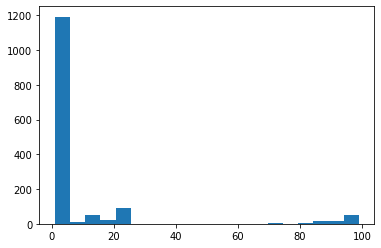

In [219]:
plt.hist(number_of_stations_per_event,20)
plt.show()

In [236]:
# Shows that 89/91 shots were detected by at least 60 stations
event_hist = np.histogram(number_of_stations_per_event,98)
low_station_ratio = sum(event_hist[0][:11])/sum(event_hist[0])
high_station_ratio = sum(event_hist[0][60:])/sum(event_hist[0])
print(str(low_station_ratio*100) + "% of events were detected on 11 stations or fewer!")
print(str(high_station_ratio*100) + "% of events were detected on 60 stations or greater!")
print("Number of known shots: 91")
print("Number of events detected of 60 stations or more: " + str(sum(event_hist[0][60:])))

83.950617284% of events were detected on 11 stations or fewer!
6.10425240055% of events were detected on 60 stations or greater!
Number of known shots: 91
Number of events detected of 60 stations or more: 89


In [234]:
# Shows that by extending down to 40 stations, every single shot is accounted for.
high_station_ratio = sum(event_hist[0][40:])/sum(event_hist[0])
print(str(low_station_ratio*100) + "% of events were detected on 11 stations or fewer!")
print(str(high_station_ratio*100) + "% of events were detected on 40 stations or greater!")
print("Number of known shots: 91")
print("Number of events detected of 40 stations or more: " + str(sum(event_hist[0][40:])))

83.950617284% of events were detected on 11 stations or fewer!
6.2414266118% of events were detected on 40 stations or greater!
Number of known shots: 91
Number of events detected of 40 stations or more: 91


In [223]:
detections_no_repeats[np.array(number_of_stations_per_event)>40]

array([UTCDateTime(2019, 1, 10, 23, 55, 0, 186999),
       UTCDateTime(2019, 1, 11, 0, 22, 0, 190999),
       UTCDateTime(2019, 1, 11, 0, 37, 0, 190999),
       UTCDateTime(2019, 1, 11, 0, 56, 0, 189999),
       UTCDateTime(2019, 1, 11, 1, 53, 0, 189999),
       UTCDateTime(2019, 1, 11, 2, 39, 0, 189999),
       UTCDateTime(2019, 1, 11, 2, 51, 0, 189999),
       UTCDateTime(2019, 1, 11, 3, 1, 0, 187999),
       UTCDateTime(2019, 1, 11, 3, 21, 0, 188000),
       UTCDateTime(2019, 1, 11, 3, 45, 0, 187999),
       UTCDateTime(2019, 1, 11, 3, 58, 0, 186000),
       UTCDateTime(2019, 1, 11, 4, 19, 0, 188999),
       UTCDateTime(2019, 1, 11, 4, 40, 0, 188000),
       UTCDateTime(2019, 1, 11, 5, 2, 0, 188999),
       UTCDateTime(2019, 1, 11, 5, 17, 0, 187999),
       UTCDateTime(2019, 1, 11, 5, 32, 0, 187999),
       UTCDateTime(2019, 1, 11, 5, 46, 0, 187999),
       UTCDateTime(2019, 1, 11, 6, 0, 0, 188000),
       UTCDateTime(2019, 1, 11, 6, 15, 0, 188000),
       UTCDateTime(2019, 1, 11, 6